In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.stats import spearmanr, pearsonr, entropy
import libpysal
from esda.moran import Moran
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

import torch
import torch.nn as nn
import torch.optim as optim

/Users/ademidemabadeje/Documents/UT/Research/PyCharm/NN_Stabilization/venv/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
data = load_wine()
target = load_wine().target
df = pd.DataFrame(data.data, columns=data.feature_names)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [3]:
num_epochs = 4000
batch_size = 16
dataset = torch.tensor(df_scaled, dtype=torch.float32)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
input_dim = df.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/ademidemabadeje/Documents/UT/Research/PyCharm/NN_Stabilization/venv/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


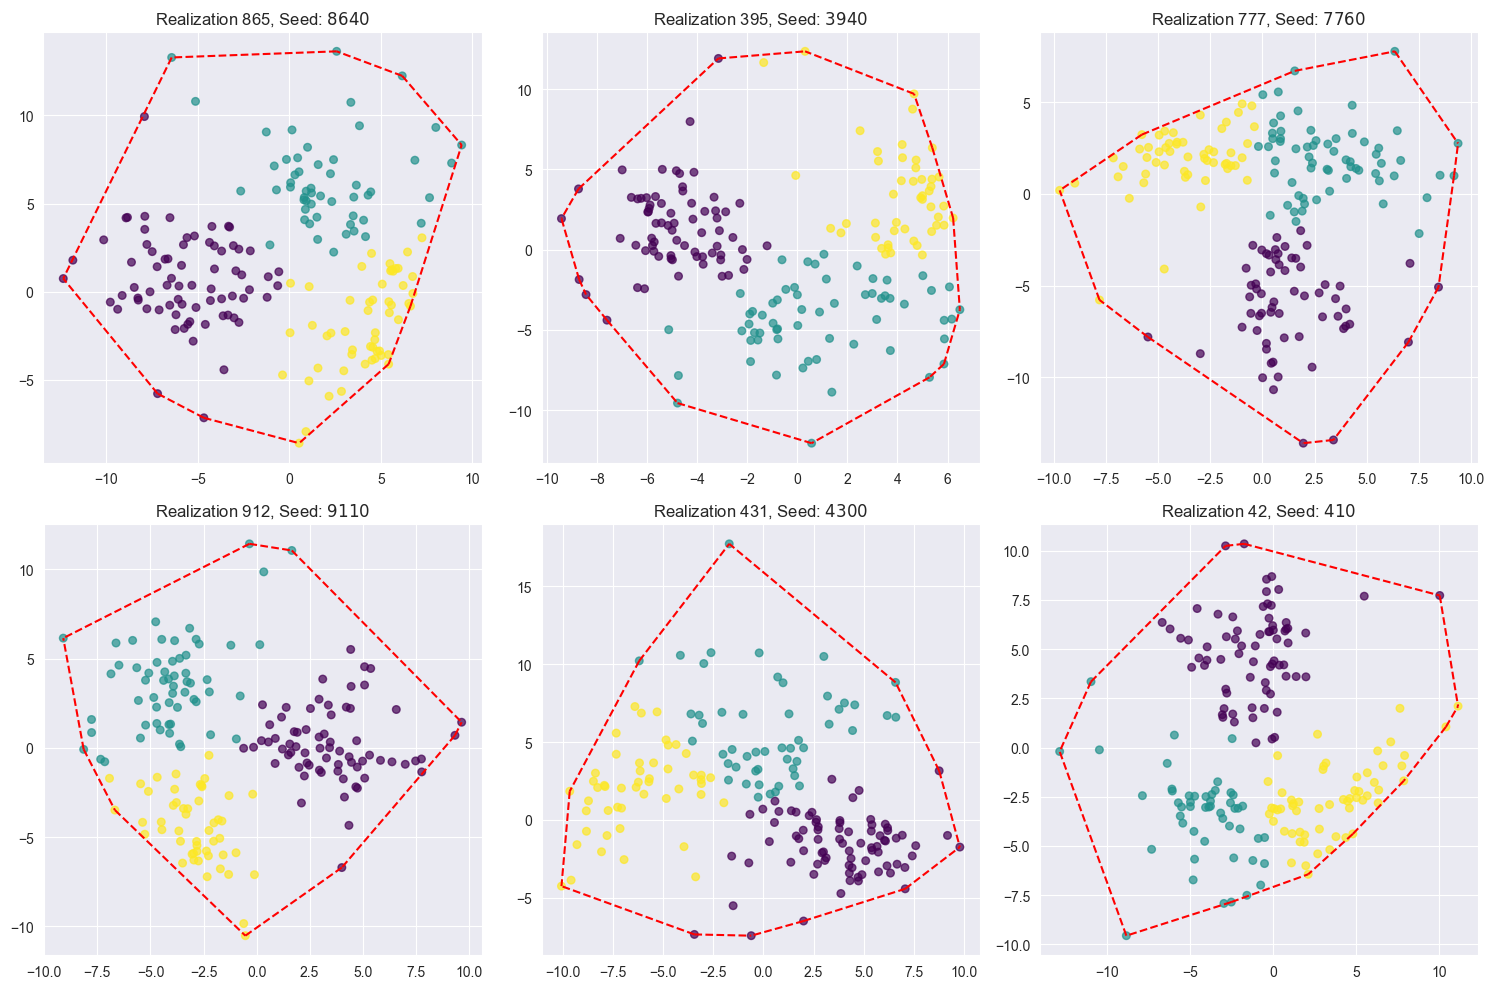

In [6]:
initial_seed = 0 # starting sequence for random seed generator
step_size = 10   # Change this to increase seeds every x units
random.seed(initial_seed)
num_seeds = 1000 # nos of realizations needed
seed_values = [initial_seed + (step_size * i) for i in range(num_seeds)]
cluster_changes = np.zeros_like(target)  # To track changes in cluster assignments
statistics_array = np.empty((num_seeds, 7))
pvalues_array = np.empty((num_seeds, 3))
convexhull_array = np.empty((num_seeds, 3))
convex_hull_vertices = []
all_loss_curves = []

# Create a 3x3 grid for visualizations
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

change_percentages = []  # List to store percentage of changed clusters for each realization

# Randomly select 6 realizations for visualization
random.seed(initial_seed)
visualization_indices = random.sample(range(num_seeds), 6)

for idx, seed in enumerate(seed_values):
    torch.manual_seed(seed)
    random.seed(seed)
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    model = Autoencoder(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(total_loss / len(dataloader))
    all_loss_curves.append(epoch_losses)


#     # Clustering in latent space
#     Here's a breakdown of how it works:
#
# 1. **Initialization**:
#    - `cluster_changes` is initialized as a zero array with the same shape as the `target` (truth labels). This means initially, all data points have 0 changes.
#    - `predicted_clusters` is computed for each realization after clustering in the latent space.
#
# 2. **Matching clusters with truth labels**:
#    - A cost matrix is computed to find the best correspondence between predicted clusters and the true labels.
#    - The Hungarian algorithm (`linear_sum_assignment`) is used to determine the optimal assignment.
#    - After the best assignment is determined, `predicted_clusters` labels are rearranged to match the true labels as closely as possible.
#
# 3. **Tracking changes**:
#    - For each data point, if its assigned cluster (`predicted_clusters`) doesn't match its true label (`target`), its corresponding value in `cluster_changes` is incremented by 1.
#    - This process is repeated for all realizations.


    with torch.no_grad():
        encoded_data = model.encoder(dataset).numpy()

    kmeans = KMeans(n_clusters=3, n_init=10).fit(encoded_data)
    predicted_clusters = kmeans.labels_

    # Matching predicted clusters to true clusters
    cost_matrix = -np.array([[np.sum((predicted_clusters[true_indices] == pred_cluster))
                              for pred_cluster in range(3)]
                             for true_indices in [np.where(target == i)[0] for i in range(3)]])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    for i in range(3):
        predicted_clusters[predicted_clusters == col_ind[i]] = -(i+10)  # Temporarily set to negative values
    for i in range(3):
        predicted_clusters[predicted_clusters == -(i+10)] = i

    changes = (predicted_clusters != target)
    change_percentages.append(100 * np.sum(changes) / len(target))
    cluster_changes += changes

    # Compute the chaos, global, and spatial statistics for each of the latent spaces for each AE realizations
    # Chaos Statistics
    array_flat = encoded_data.flatten()
    values, counts = np.unique(array_flat, return_counts=True)
    probabilities = counts / counts.sum()
    entropy_values = entropy(probabilities, base=2) # s1

    # Global Statistics
    mean_global = np.mean(encoded_data) # s2
    variance_global = np.var(encoded_data) # s3
    norm_fro = np.linalg.norm(encoded_data, 'fro') # s4
    # pearson2 = np.corrcoef(encoded_data[:, 0], encoded_data[:, 1])[0,1]
    pearson, coef_pval = pearsonr(encoded_data[:,0], encoded_data[:,1]) # s5
    spearman, rank_pval = spearmanr(encoded_data[:,0], encoded_data[:,1]) # s6

    # Spatial Statistics
    weights = libpysal.weights.lat2W(encoded_data.shape[0],encoded_data.shape[1], rook=False, id_type="float")
    np.random.seed(seed)

    mi = Moran(encoded_data, weights) # two_tailed=False for one tailed Moran, emeasure of overall spatial autocorrelation -1: perfect clustering of dissimilar values/objects (perfect dispersion), 0: perfect randomness, 1: perfect clustering of similar values/objects.
    moran = mi.I # s7
    moran_pval = mi.p_norm

    # Store the computed statistics in the array for this iteration
    statistics_array[idx, :] = [entropy_values, mean_global, variance_global, norm_fro, pearson, spearman, moran]
    pvalues_array[idx, :] = [coef_pval, rank_pval, moran_pval]

    # Save statistics and pvalues array to numpy files
    np.save('statistics_array.npy', statistics_array)
    np.save('pvalues_array.npy', pvalues_array)

    # Compute convex hull and associated attributes
    my_points = encoded_data.copy()
    hull = ConvexHull(my_points)
    vertices_idx = hull.vertices
    vertices = my_points[hull.vertices]
    polygon = Polygon(vertices)

    # Store computed variables needed from convex hull polygon i.e., the number of vertices, area, and volume for each AE realization
    convexhull_array[idx, :] = [len(vertices), hull.area, hull.volume]
    convex_hull_vertices.append(vertices_idx)

    # Save convex hull attributes to numpy files
    np.save('convexhull_array.npy', convexhull_array)

    # Check if the current realization index is in the list of visualization_indices
    if idx in visualization_indices:
        # Visualization of latent space in 3x3 grid
        axs[visualization_indices.index(idx)].scatter(encoded_data[:, 0], encoded_data[:, 1], c=predicted_clusters, cmap='viridis', marker='o', s=30,
                      alpha=0.7)
        axs[visualization_indices.index(idx)].set_title(f"Realization {idx + 1}, Seed: ${seed}$")

        for simplex in hull.simplices:
            axs[visualization_indices.index(idx)].plot(my_points[simplex, 0], my_points[simplex, 1], 'r--')
            #axs[visualization_indices.index(idx)].fill(my_points[hull.vertices, 0], my_points[hull.vertices, 1], c='yellow', alpha=0.01)

plt.tight_layout()
plt.savefig('LS Visualization for Select AE Realizations with CH.png', dpi=300, bbox_inches='tight')
plt.show()

The choice of Jaccard similarity for analyzing the vertices of convex hulls across different realizations of an autoencoder is primarily due to its suitability for comparing sets, especially when the elements of these sets are categorical or discrete, like indices in this case. Here are some key reasons why Jaccard similarity is a good fit for this analysis:

1. **Measuring Overlap in Sets:** Jaccard similarity is specifically designed to measure the similarity between finite sets. It's calculated as the size of the intersection divided by the size of the union of the sets. In the context of convex hull vertices, it quantifies how many vertices are common between any two realizations relative to the total unique vertices in both.

2. **Applicability to Your Analysis:** In your scenario, you're comparing sets of indices (vertices of convex hulls). Jaccard similarity directly addresses this by evaluating how similar these sets are across different realizations, providing a clear and interpretable metric for the stability of your model's latent space representations.

3. **Robustness to Size Variations:** The Jaccard index is robust to variations in the size of the sets. It's particularly useful when the number of vertices in the convex hulls might change across realizations, as it normalizes the similarity by the union of the sets.

4. **Intuitive and Interpretable:** The Jaccard similarity yields a value between 0 and 1, where 1 indicates identical sets and 0 indicates no common elements. This makes it easy to interpret in terms of similarity or dissimilarity.

5. **Widely Used in Comparative Analysis:** Jaccard similarity is a well-established metric in various fields including biology (for species similarity), text analysis (similarity of documents), and machine learning (comparing clusters or sets), making it a reliable choice.

Given these properties, Jaccard similarity provides a straightforward and effective way to compare the convex hull vertices across different model realizations and to gauge the stability and consistency of the model's inferences.


Jaccard Similarity of 1: A Jaccard similarity score of 1 means that the sets of vertices (convex hulls) being compared are exactly the same. This would mean that two realizations of the autoencoder have produced identical sets of vertices for their convex hulls. This indicates total stability, as the model's latent space representation is consistent across these AE realizations.

Jaccard Similarity of 0: Conversely, a Jaccard similarity score of 0 means that there is no overlap between the sets; they are completely different. For my application, this implies total instability, as the sets of vertices (anchor points in the latent space) for the convex hulls in these two realizations do not match at all.
Therefore, in terms of evaluating the stability of the model's latent space representations across different AE realizations:

High Jaccard scores (close to 1) across most pairs of realizations suggest a high degree of stability. (Hence the use of neffective to determine how many AE realizations is needed to attain stability in the latent space for inference making)

Lower Jaccard scores (especially those close to 0) indicate more variability or instability in how the model is representing the data under different initializations.

In [9]:
from itertools import combinations

# To compare the sets of vertices from the convex hulls across different realizations, use set operations. The idea is to assess the overlap and differences between the sets of indices for each pair of realizations.

comparisons = {}
for (i, vertices_i), (j, vertices_j) in combinations(enumerate(convex_hull_vertices), 2):
    set_i, set_j = set(vertices_i.tolist()), set(vertices_j.tolist())
    intersection = set_i.intersection(set_j)
    union = set_i.union(set_j)
    jaccard_similarity = len(intersection) / len(union) if union else 1
    comparisons[(i, j)] = jaccard_similarity

In [10]:
# Visualize the jaccard similarity scores via heat map
import seaborn as sns

# Number of realizations
num_realizations = len(convex_hull_vertices)

# Create a matrix to store the Jaccard similarity scores
similarity_matrix = np.zeros((num_realizations, num_realizations))

# Fill the matrix with your calculated Jaccard similarities
for (i, j), similarity in comparisons.items():
    similarity_matrix[i, j] = similarity
    similarity_matrix[j, i] = similarity  # Mirror the similarity as the matrix is symmetric

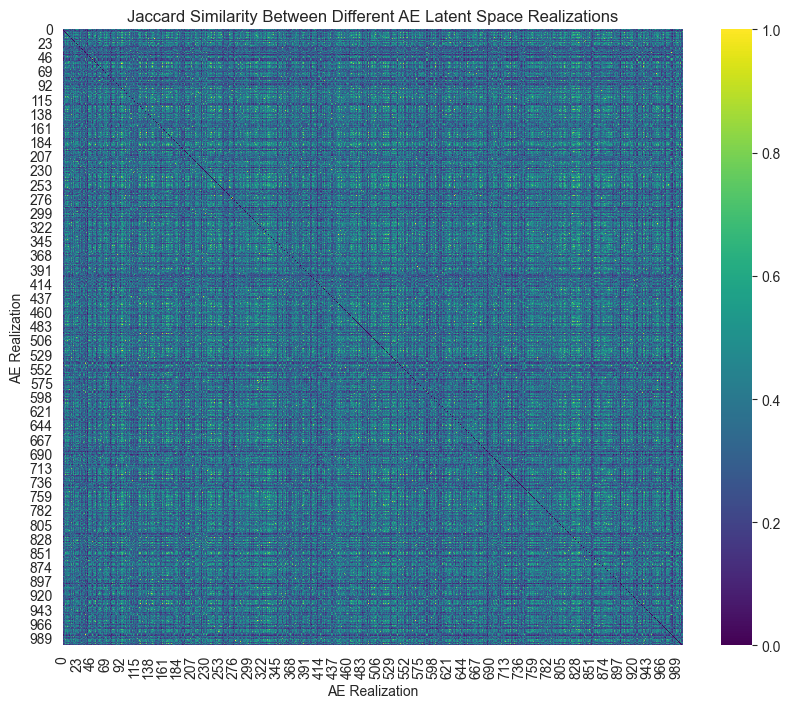

In [11]:
# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis')
plt.title('Jaccard Similarity Between Different AE Latent Space Realizations')
plt.xlabel('AE Realization')
plt.ylabel('AE Realization')
plt.savefig('UnSorted Similarity Matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
from fastcluster import linkage
from scipy.spatial.distance import squareform, pdist

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    """
    This function checks if the distance matrix is symmetric, prior to making a sorted dissimilarity matrix
    """
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


def seriation(Z, N, cur_index):
    """
    This is a function that creates a sorted 2D matrix as a figure

        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z

        seriation computes the order implied by a hierarchical tree (dendrogram)
    """

    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return seriation(Z, N, left) + seriation(Z, N, right)


def compute_serial_matrix(dist_mat, method="ward"):
    """
        input:
            - dist_mat is a distance matrix
            -  = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarchical tree
            - res_linkage is the hierarchical tree (dendrogram)

        compute_serial_matrix transforms a distance matrix into
        a sorted distance matrix according to the order implied
        by the hierarchical tree (dendrogram)
    """

    N = len(dist_mat)
    flat_dist_mat = dist_mat if len(dist_mat.shape) == 2 else squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method, preserve_input=True)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a, b = np.triu_indices(N, k=1)
    seriated_dist[a, b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b, a] = seriated_dist[a, b]

    return seriated_dist, res_order, res_linkage

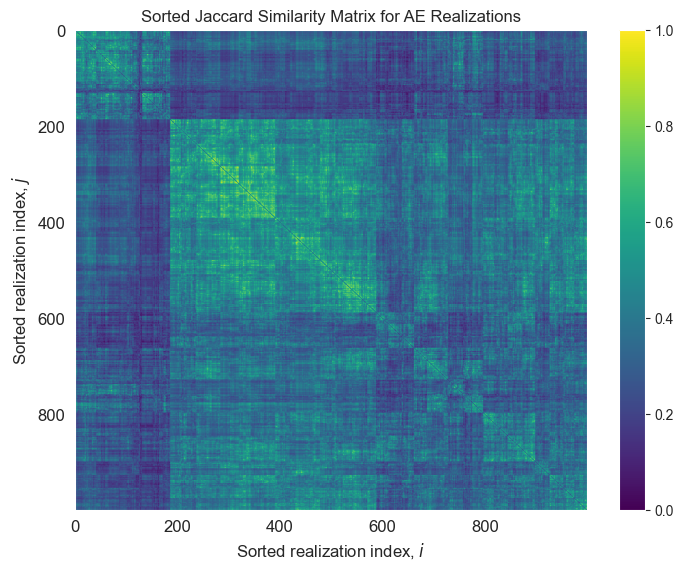

In [13]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(similarity_matrix,"ward")
fig, ax1 = plt.subplots(1, 1)

#subplot 1
im1 = ax1.imshow(ordered_dist_mat, cmap='viridis')

# Figure info
ax1.set_aspect('auto')
ax1.set_title('Sorted Jaccard Similarity Matrix for AE Realizations', size=12)
ax1.set_xlabel('Sorted realization index, $i$', size=12)
ax1.set_ylabel('Sorted realization index, $j$', size=12)
ax1.tick_params(axis='both', which='major', labelsize=12)


# Aesthetics
axis = fig.add_axes([0.85, 0.30, 0.04, 1.0])  # Left,bottom, width, length
cbar = fig.colorbar(im1, cax=axis, orientation='vertical')
plt.subplots_adjust(left=0.0, bottom=0.3, right=0.8, top=1.3, wspace=0.25, hspace=0.3)
plt.savefig('Sorted Similarity Matrices.png', dpi=300, bbox_inches='tight')
ax1.grid(visible=False)
plt.show()

In [14]:
change_anchors = [] # contains a list of the percentage change in vertices/anchor points for each consecutive pair of AE realizations.

for i in range(0, len(convex_hull_vertices)):
    prev_set = set(convex_hull_vertices[i-1])
    current_set = set(convex_hull_vertices[i])
    changed_vertices = current_set.symmetric_difference(prev_set)
    total_vertices = len(prev_set.union(current_set))
    change_anchor = len(changed_vertices) / total_vertices * 100
    change_anchors.append(change_anchor)

 Note that this is a sequential comparison and not comprehensive across all AE realization pairs. If you want a global stability/instability view, then consider the Jaccard similarity instead.

The sequential change percentage in anchors is useful for understanding the immediate stability of the model from one realization to the next. It can highlight how sensitive the model is to small changes in the random seed or initialization parameters. On the other hand, the Jaccard similarity across all pairs of realizations offers a broader view of overall stability and consistency across the entire range of realizations.

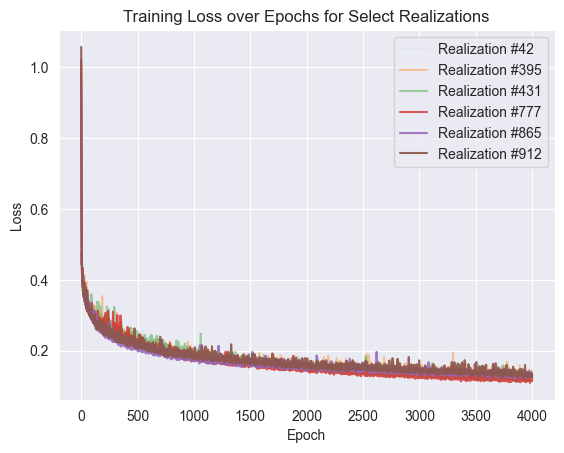

In [15]:
# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]

# Visualize loss functions for select realizations
for idx, losses in enumerate(all_loss_curves):
    if idx in visualization_indices:
        plt.plot(losses, label=f'Realization #{idx+1}', alpha=alphas[idx])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Select Realizations')
plt.legend()
plt.savefig('Training loss over select realizations.png', dpi=300, bbox_inches='tight')
plt.show()

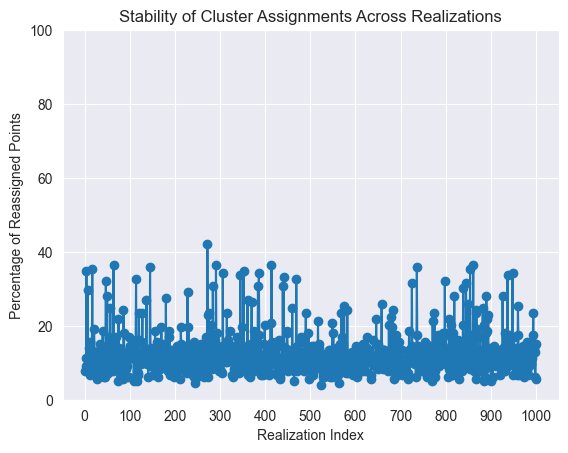

In [16]:
# Analyzing changes in cluster assignments using a line plot i.e., instability plot
plt.figure()
plt.plot(range(1, num_seeds+1), change_percentages, '-o')
plt.xlabel('Realization Index')
plt.ylabel('Percentage of Reassigned Points')
plt.title('Stability of Cluster Assignments Across Realizations')
plt.xticks(np.arange(0, num_seeds+1, 100))
plt.ylim([0, 100])  # y-axis limits between 0 and 100 for percentages
plt.savefig('Stability of Cluster Assignments Across Realizations.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
arr_changes = np.array(change_percentages)
sorted_data = np.sort(arr_changes)

# Calculate the 5-point statistic
minimum = np.min(sorted_data)
maximum = np.max(sorted_data)
median = np.median(sorted_data)
q1 = np.percentile(sorted_data, 25)
q3 = np.percentile(sorted_data, 75)
variance = np.var(sorted_data)

# Display the five-number summary
print("Minimum:", round(minimum, 5))
print("First Quartile (Q1):", round(q1, 5))
print("Median (Q2):", round(median, 5))
print("Third Quartile (Q3):", round(q3, 5))
print("Maximum:", round(maximum, 5))
print("Variance:", round(variance, 5))

Minimum: 3.93258
First Quartile (Q1): 8.98876
Median (Q2): 11.23596
Third Quartile (Q3): 13.48315
Maximum: 42.13483
Variance: 29.3022


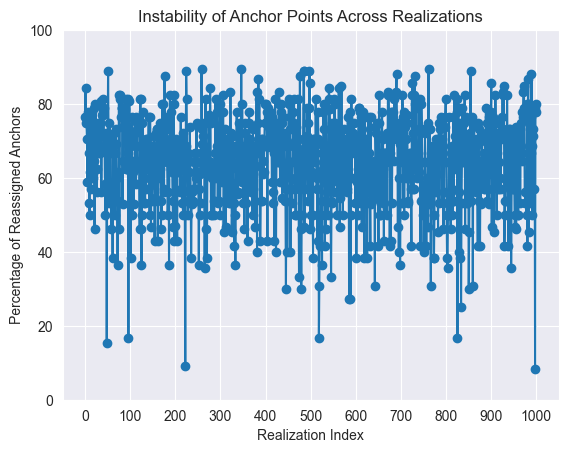

In [18]:
# Analyzing changes in cluster assignments using a line plot i.e., anchor-based instability plot
plt.figure()
plt.plot(range(0, num_seeds), change_anchors, '-o')
plt.xlabel('Realization Index')
plt.ylabel('Percentage of Reassigned Anchors')
plt.title('Instability of Anchor Points Across Realizations')
plt.xticks(np.arange(0, num_seeds+1, 100))
plt.ylim([0, 100])  # y-axis limits between 0 and 100 for percentages
plt.savefig('Instability of Anchor Points Across Realizations.png', dpi=300, bbox_inches='tight')
plt.show()

**Recall in each realization, we do the following:**

1. Train an autoencoder, and then applying k-means to the latent space to identify clusters.
2. These clusters are then matched to the true labels to minimize the discrepancies between predicted and true cluster assignments.
3. After matching, for each data point, if the matched predicted cluster is different from its true label, it's considered a "change", and the corresponding entry in `cluster_changes` is incremented.

The `cluster_changes` array accumulates these "changes" for each data point over all realizations. After all realizations are done, the value for a data point in `cluster_changes` represents how many times (out of all realizations) the predicted cluster for that data point didn't match its true label. This becomes a tell-tale sign of stability in the latent feature space.

The introduction of stochastic uncertainty through changing the random seed is a way to account for and analyze the variability in model training and performance. By training a model multiple times with different seeds, you can assess the robustness of the model and gain insights into how sensitive it is to variations in initialization and training data presentation. It helps in understanding the model's generalization and can be useful for hyperparameter tuning and model evaluation.


**Advantages of Minibatch Training for Small Datasets:**

1. Regularization: Minibatch training introduces noise into the training process, which can act as a form of regularization. This can help prevent overfitting, even on small datasets.
2. Efficiency: Minibatch training allows you to take advantage of parallelism, such as using GPUs, which can significantly speed up training even for small datasets.
3. Convergence: Minibatch training can lead to faster convergence, which means your model reaches a good solution more quickly.
4. Memory Efficiency: Training on the full dataset might not fit into memory, especially when the dataset is very large. Minibatch training allows you to work with smaller portions of the data at a time.

**Considerations for Minibatch Training on Small Datasets:**

1. Batch Size: When working with a small dataset, you should carefully choose the batch size. Very small batch sizes can introduce high variance in gradient updates, while very large batch sizes may not provide the regularization benefits of minibatch training. You may need to experiment to find the optimal batch size for your specific dataset and model.
2. Learning Rate: Smaller batch sizes may require smaller learning rates to prevent overshooting during optimization. Again, hyperparameter tuning may be necessary.
3. Validation Set: With a small dataset, it's crucial to have a validation set to monitor model performance. Overfitting can still occur, especially if your model has many parameters.
4. Data Augmentation: Data augmentation techniques (e.g., flipping, rotating, cropping) can help artificially increase the effective size of your dataset, making minibatch training more effective.
5. Transfer Learning: If your small dataset is similar to a larger dataset, you can consider using pre-trained models and fine-tuning them on your dataset.
6. In summary, while minibatch training can be beneficial for small datasets, it requires careful consideration of batch size, learning rate, and other hyperparameters. Additionally, techniques like data augmentation and transfer learning can be used to make the most of small datasets. Ultimately, the choice of whether to use minibatch training or not depends on the specific problem and constraints you are dealing with.


Idea of using the convex hull vertices to study the variability of inferences in different autoencoder realizations is quite innovative and can be a valuable approach. Here's why this could be beneficial and how you might go about it:


**Advantages of Using Convex Hull Vertices:**
1. Stability Analysis: By examining how the vertices of the convex hull change with different random seeds, you can assess the stability and robustness of the autoencoder. Consistent vertices across different realizations suggest that the autoencoder is reliably capturing the same underlying structure in the data.
2. Identifying Anchor Points: Convex hull vertices can serve as "anchor points" in your latent space, providing a way to understand the extremities or boundaries of the representations learned by the autoencoder.
3. Quantitative Analysis: Changes in the vertices can be quantified, allowing for a more systematic analysis of variability. Metrics like the distance between corresponding vertices in different realizations, or the area/volume of the convex hulls, can provide insights into the variability induced by different seeds.


**Implementing the Analysis:**
1. Compute Convex Hull: For each autoencoder realization, use the encoded latent space representations to compute the convex hull. Tools like scipy.spatial.ConvexHull in Python can be useful for this.
2. Compare Vertices: Analyze how the vertices of these convex hulls vary across different realizations. You might consider:
    * The position of vertices.
    * The number of vertices.
    * Geometric properties like the area or volume enclosed by the convex hull.
3. Statistical Analysis: Perform statistical tests or visualizations to understand the degree of variability. For instance, plotting the convex hulls from different realizations can visually show the differences.
4. Correlation with Seeds: Investigate if there's any pattern or correlation between the changes in the convex hull and the random seeds used. This might reveal how sensitive the autoencoder's latent space is to initialization.

**Considerations:**
1. Dimensionality: If your latent space is high-dimensional, the interpretation of convex hulls can become complex. Consider dimensionality reduction techniques for visualization and analysis.
2. Comparability: Ensure that the method used for comparing vertices is consistent and meaningful across different realizations.


In summary, using the convex hull vertices to analyze the impact of different random seeds on the latent space of an autoencoder is a promising approach. It can provide insights into the stability and variability of the autoencoder's learned representations, aiding in the understanding of how different initializations affect the model's inferences.


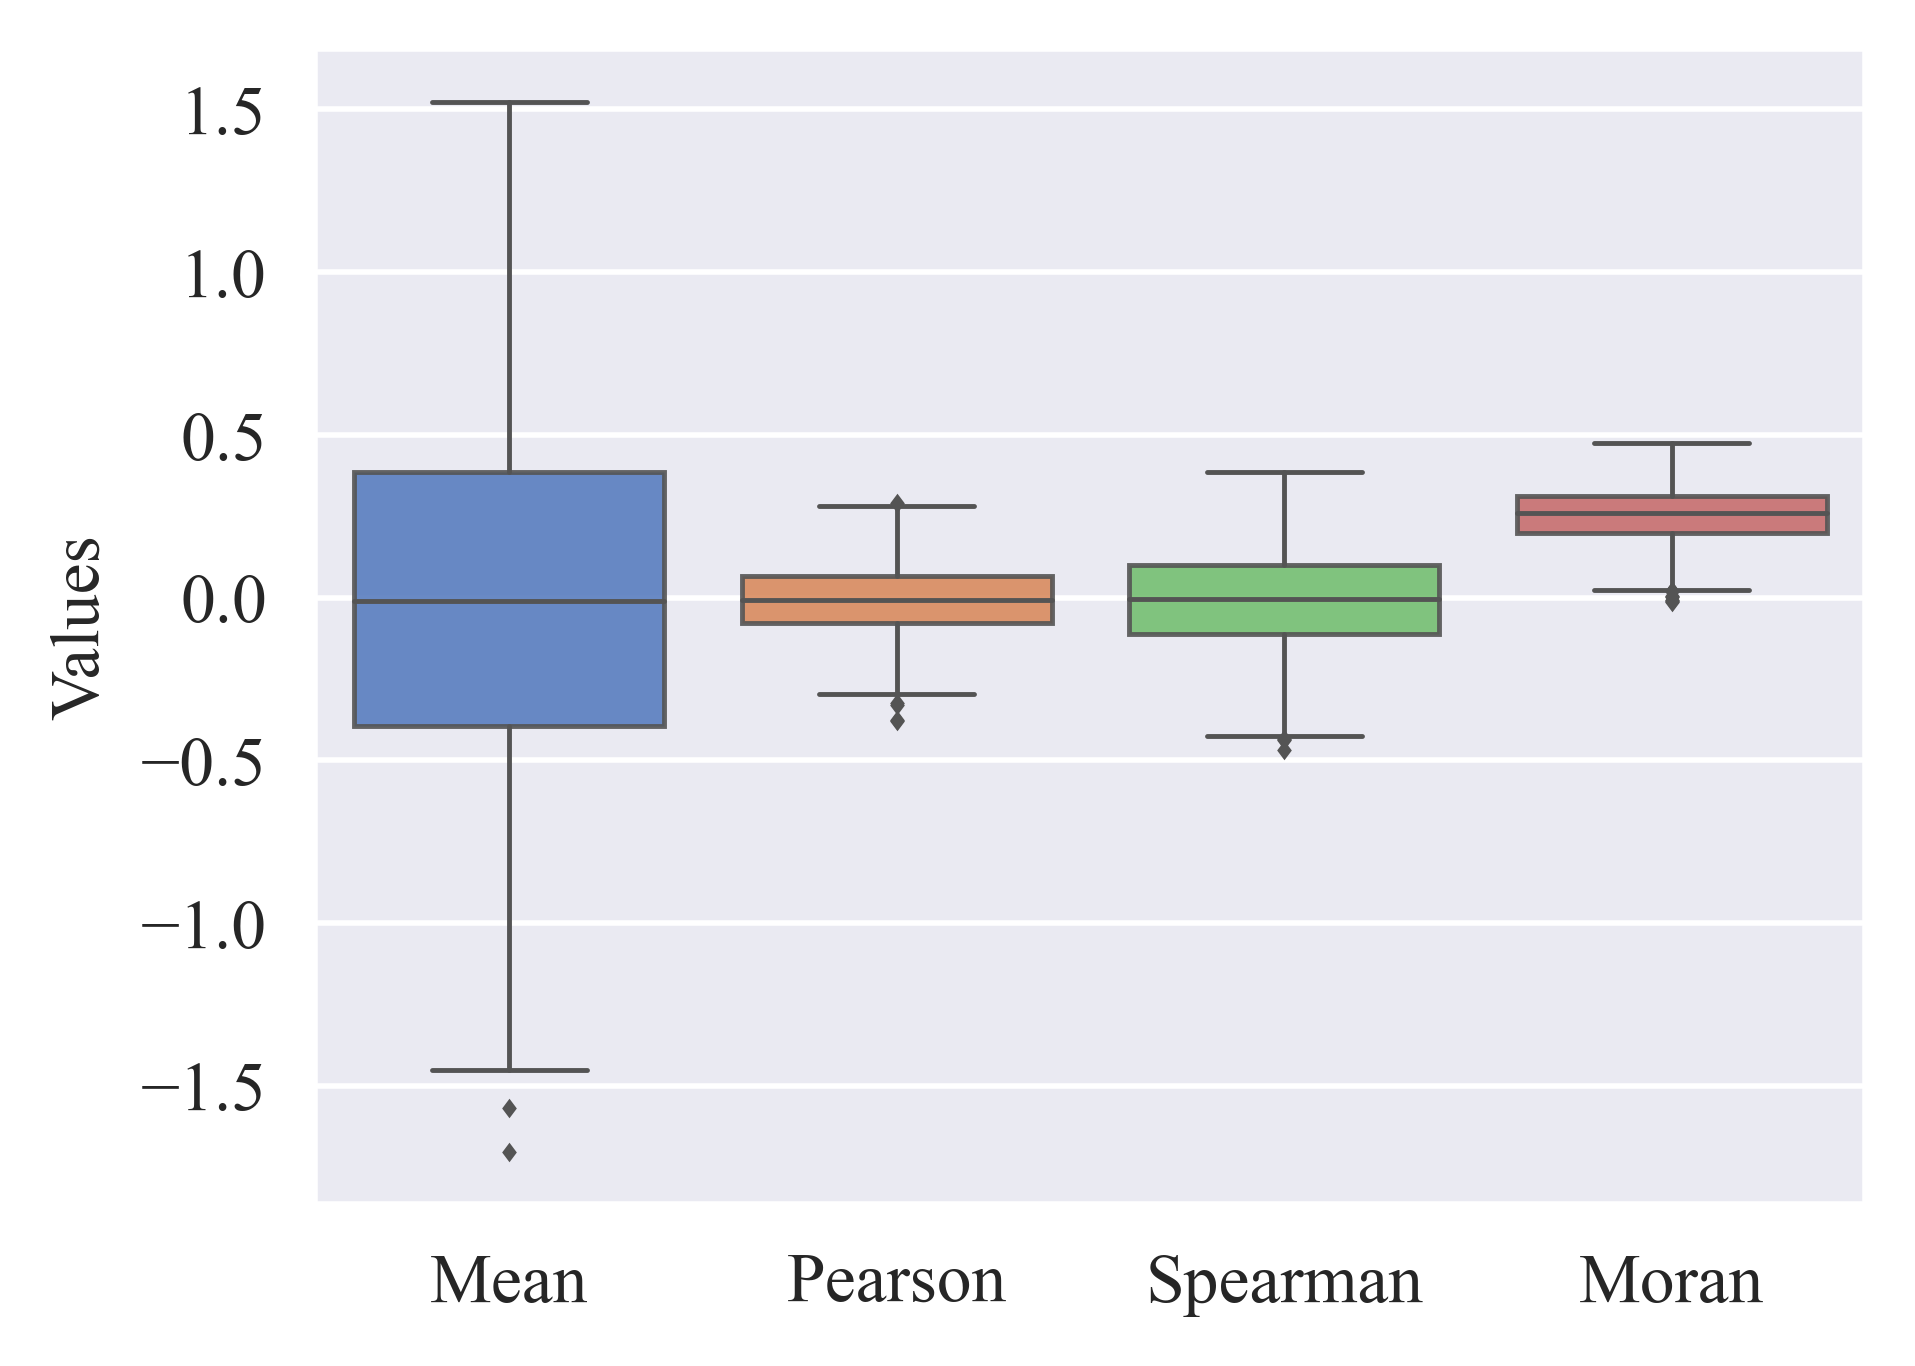

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

data_dict = {
    'Mean': statistics_array[:, 1],
    'Pearson': statistics_array[:, 4],
    'Spearman': statistics_array[:, 5],
    'Moran': statistics_array[:, 6]
}

df = pd.DataFrame(data_dict)

# Melt the DataFrame to reshape it
df = pd.melt(df, var_name='Statistics', value_name='Values')

mpl.rcParams['figure.dpi'] = 500
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.figure(figsize=(4,3))
sns.boxplot(data = df, x="Statistics", y="Values", boxprops=dict(alpha=.9),palette="muted",linewidth=0.7,fliersize=0.9)
plt.ylabel('Values',fontsize=10)
plt.xlabel('')
plt.savefig('Global statistics for all AE realizations.png', dpi=300, bbox_inches='tight')
plt.show()

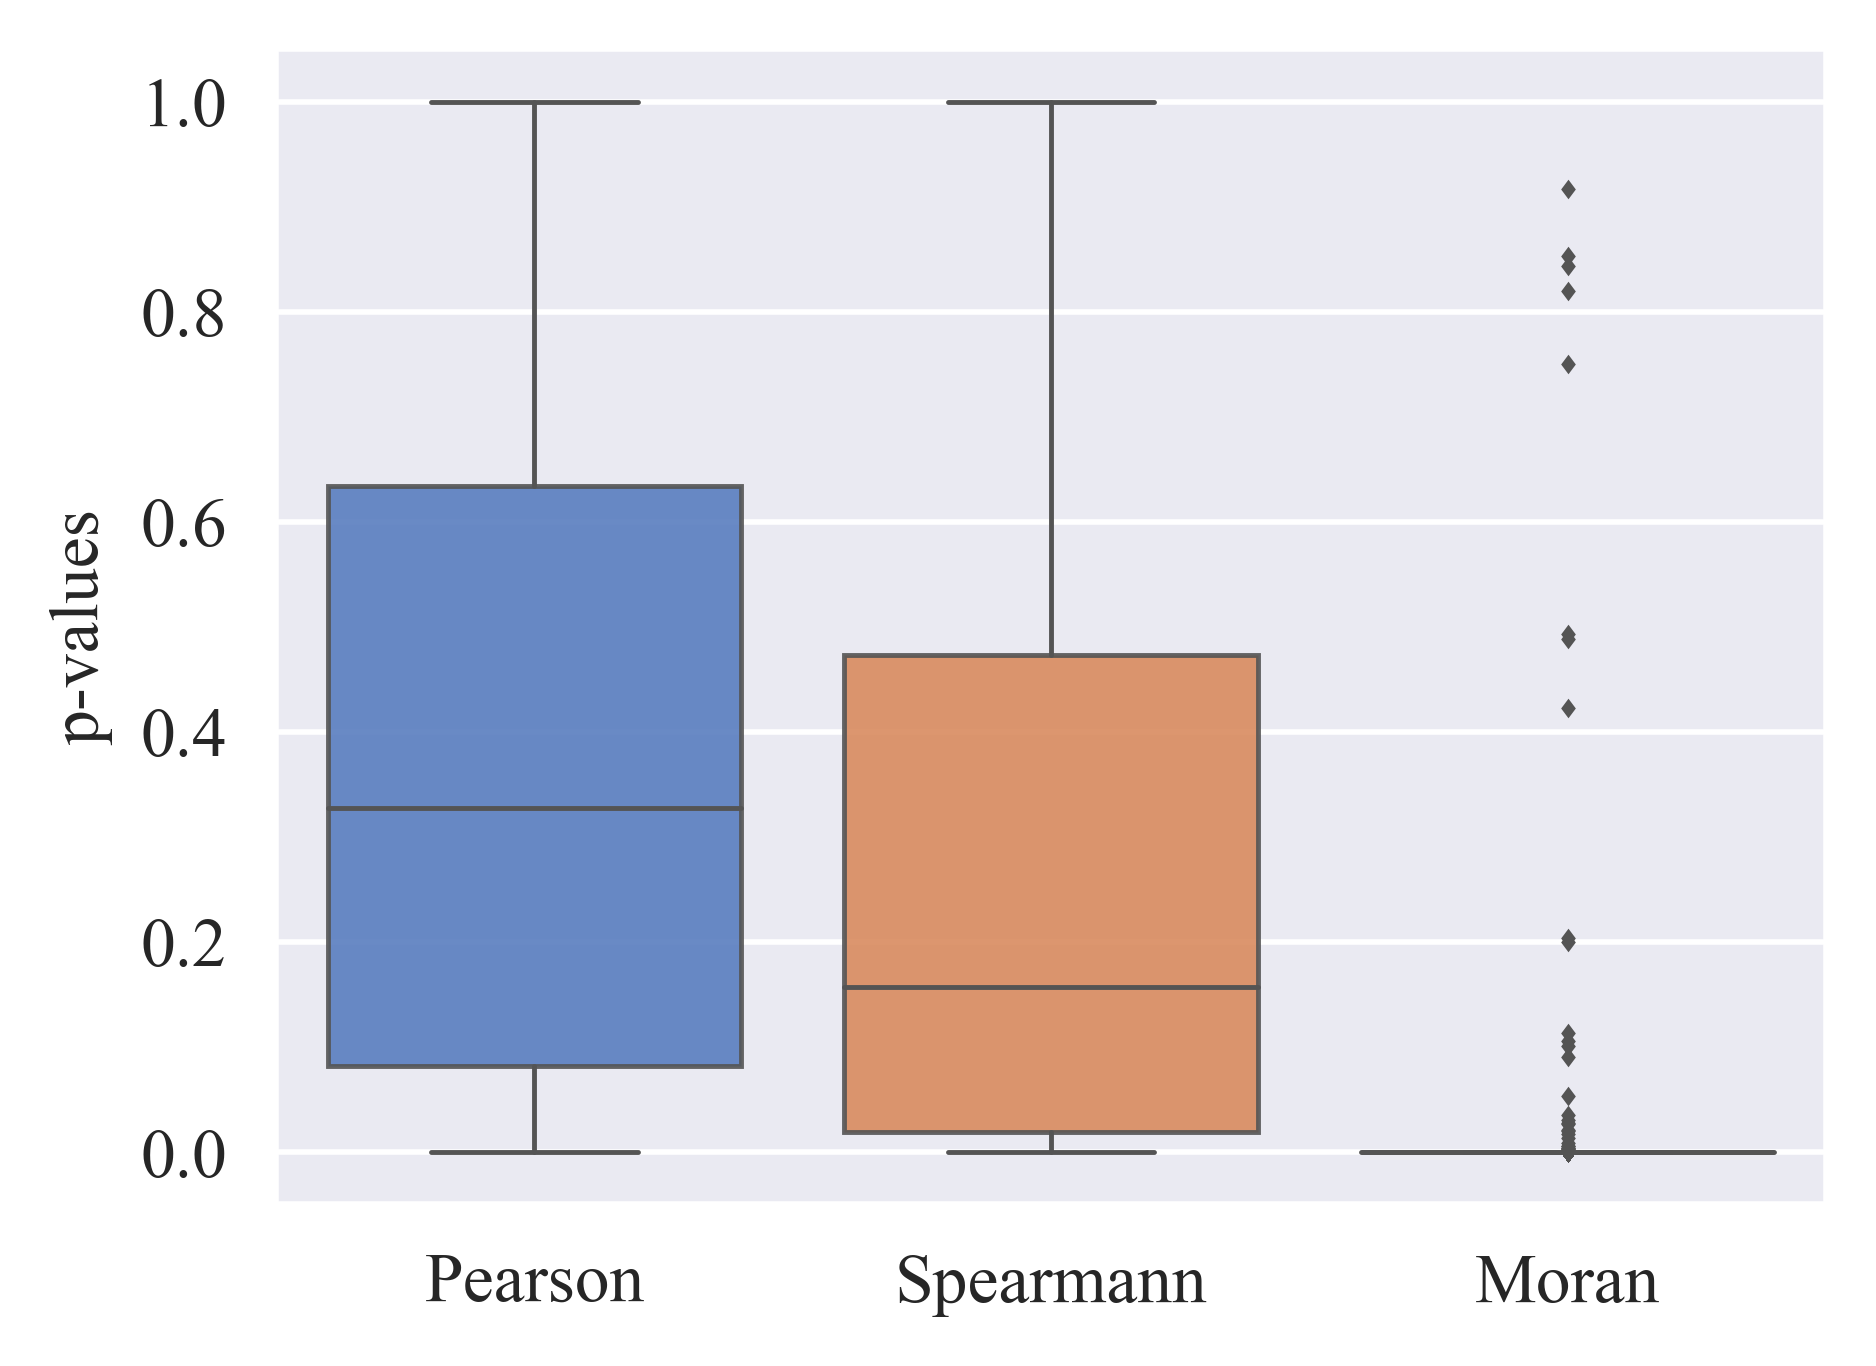

In [20]:
pval_dict = {
    'Pearson': pvalues_array[:, 0],
    'Spearmann': pvalues_array[:, 1],
    'Moran': pvalues_array[:, 2]
}

df = pd.DataFrame(pval_dict)

# Melt the DataFrame to reshape it
df = pd.melt(df, var_name='Statistics', value_name='p-values')

mpl.rcParams['figure.dpi'] = 500
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.figure(figsize=(4,3))
sns.boxplot(data = df, x="Statistics", y="p-values", boxprops=dict(alpha=.9),palette="muted",linewidth=0.7,fliersize=0.9)
plt.ylabel('p-values',fontsize=10)
plt.xlabel('')
plt.savefig('P-values for all AE realizations.png', dpi=300, bbox_inches='tight')
plt.show()

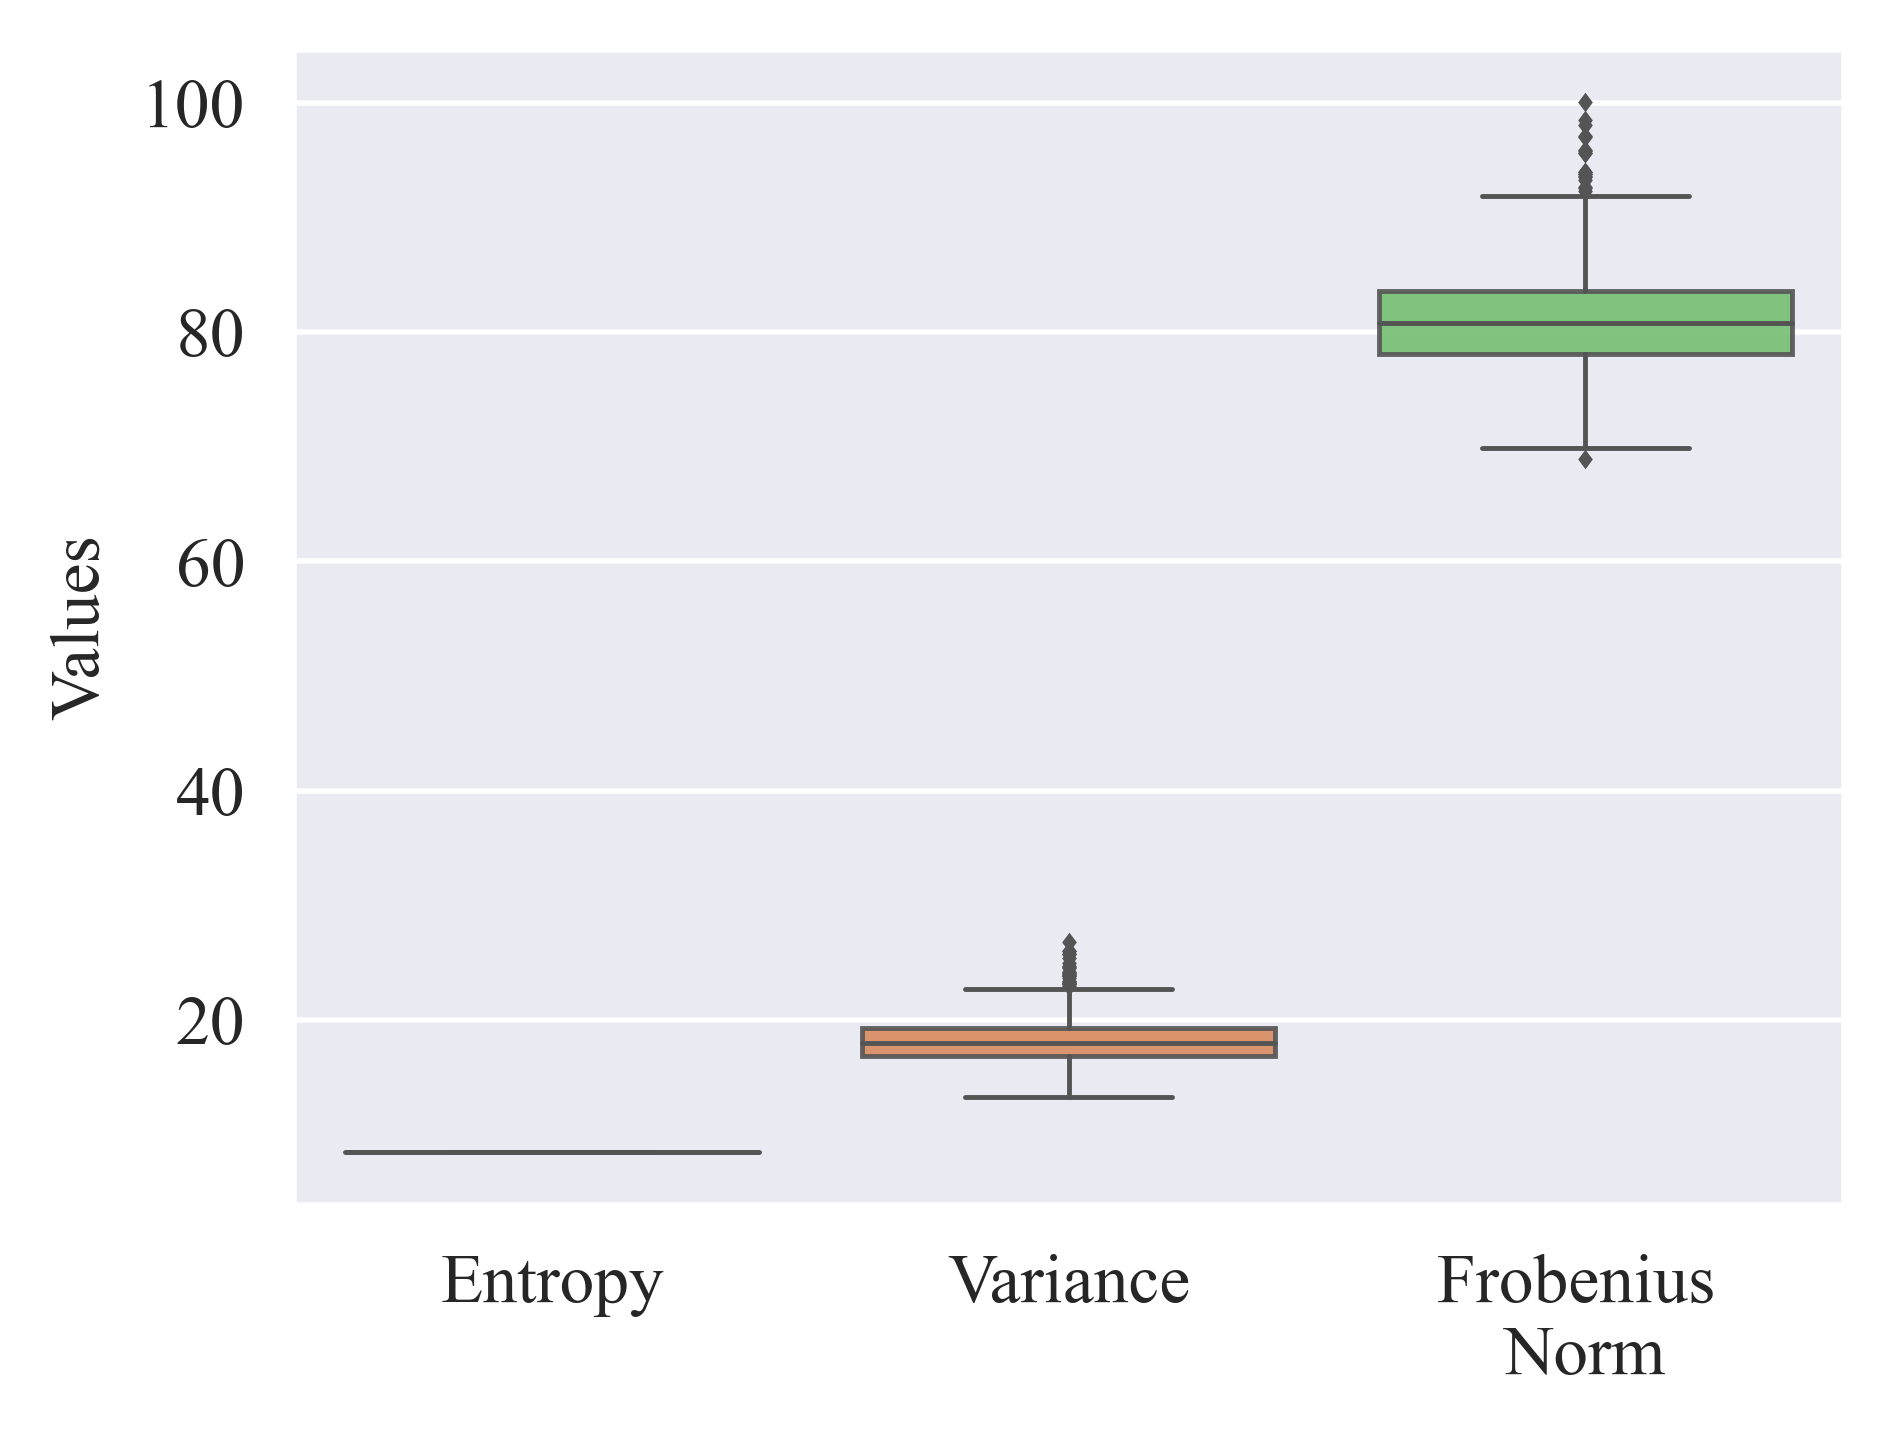

In [21]:
data_dict2 = {'Entropy': statistics_array[:, 0],
              'Variance': statistics_array[:, 2],
             'Frobenius \nNorm': statistics_array[:, 3]
              }

df2 = pd.DataFrame(data_dict2)

# Melt the DataFrame to reshape it
df2 = pd.melt(df2, var_name='Statistics', value_name='Values')

mpl.rcParams['figure.dpi'] = 500
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.figure(figsize=(4,3))
sns.boxplot(data = df2, x="Statistics", y="Values", boxprops=dict(alpha=.9),palette="muted",linewidth=0.7,fliersize=0.9)
plt.ylabel('Values',fontsize=10)
plt.xlabel('')
plt.savefig('Other statistics for all AE realizations.png', dpi=300, bbox_inches='tight')
plt.show()

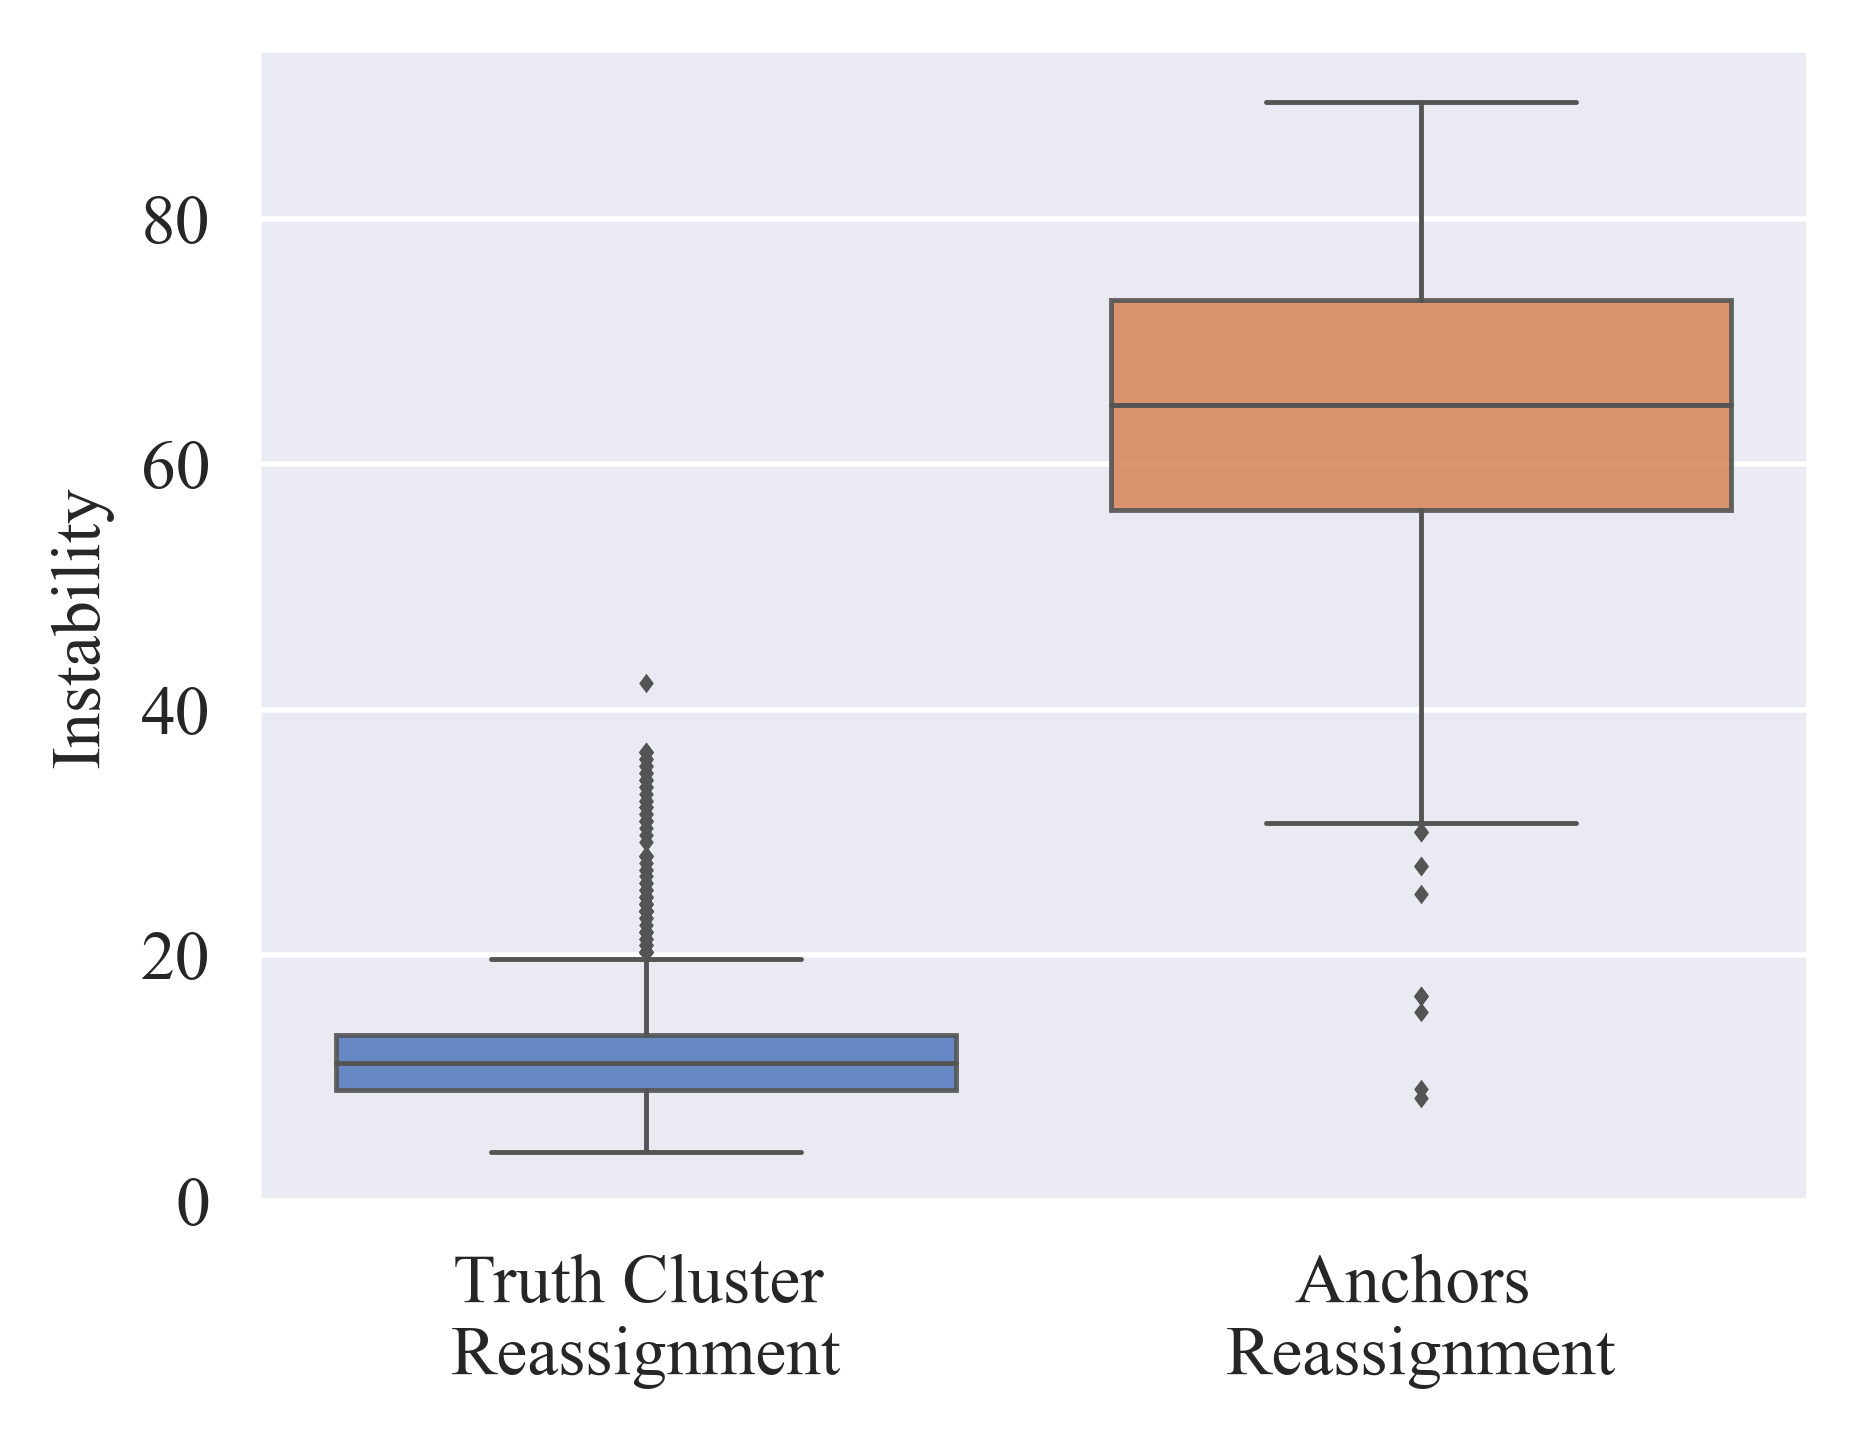

In [22]:
data_dict3 = {
              'Truth Cluster \nReassignment': np.array(change_percentages),
              'Anchors \nReassignment': np.array(change_anchors)
              }


df3 = pd.DataFrame(data_dict3)

# Melt the DataFrame to reshape it
df3 = pd.melt(df3, var_name='Reassignments', value_name='Instability')

mpl.rcParams['figure.dpi'] = 500
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.figure(figsize=(4,3))
sns.boxplot(data = df3, x="Reassignments", y="Instability", boxprops=dict(alpha=.9),palette="muted",linewidth=0.7,fliersize=0.9)
plt.ylabel('Instability',fontsize=10)
plt.xlabel('')
plt.savefig('Instability measures over clusters and anchors.png', dpi=300, bbox_inches='tight')
plt.show()


In [26]:
np.min(all_loss_curves)

0.09264404947559039